In [2]:
import librosa
import librosa.display
import sklearn
from unicodedata import normalize
from sklearn import preprocessing
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random

In [31]:
audio_file = '/home/crysis/Workspace/STT-cnn/dataset/ddra/ddra3.wav'

In [4]:
audio, sr = librosa.load(audio_file, sr=16000)
print('sr:', sr, ', audio shape:', audio.shape)
print('length:', audio.shape[0]/float(sr), 'secs')

NameError: name 'audio_file' is not defined

In [2]:
mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)

NameError: name 'audio' is not defined

In [3]:
pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
# padded_mfcc = pad2d(mfcc, 140)

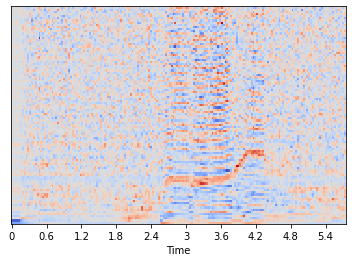

In [42]:
librosa.display.specshow(padded_mfcc, sr=16000, x_axis='time')

In [4]:
DATA_DIR = '/home/crysis/Workspace/STT-cnn/dataset/'
trainset = []

for filename in os.listdir(DATA_DIR + "train/"):
#     filename = normalize('NFC', filename)
    try:
        if '.wav' not in filename in filename:
            continue

        audio, sr = librosa.load(DATA_DIR+ "train/"+ filename, sr=16000)

        mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)

  
        if filename[:4] == 'gode':
            trainset.append((padded_mfcc, 0))
        elif filename[:4] == 'kimc':
            trainset.append((padded_mfcc, 1))
        elif filename[:4] == 'king':
            trainset.append((padded_mfcc, 2))
        elif filename[:4] == 'yook':
            trainset.append((padded_mfcc, 3))         
    except Exception as e:
        print(filename, e)
        raise


random.shuffle(trainset)

In [5]:
testset = []

for filename in os.listdir(DATA_DIR + "test/"):
#     filename = normalize('NFC', filename, norm='l1')
    try:
        if '.wav' not in filename in filename:
            continue

        audio, sr = librosa.load(DATA_DIR+ "test/"+ filename, sr=16000)

        mfcc = librosa.feature.mfcc(audio, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
        mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
        padded_mfcc = pad2d(mfcc, 400)

        if filename[:4] == 'gode':
            testset.append((padded_mfcc, 0))
        elif filename[:4] == 'kimc':
            testset.append((padded_mfcc, 1))
        elif filename[:4] == 'king':
            testset.append((padded_mfcc, 2))
        elif filename[:4] == 'yook':
            testset.append((padded_mfcc, 3))     
    except Exception as e:
        print(filename, e)
        raise


random.shuffle(testset)

In [7]:
train_mfccs = [a for (a,b) in trainset]
train_y = [b for (a,b) in trainset]

test_mfccs = [a for (a,b) in testset]
test_y = [b for (a,b) in testset]

train_mfccs = np.array(train_mfccs)
train_y = to_categorical(np.array(train_y))

test_mfccs = np.array(test_mfccs)
test_y = to_categorical(np.array(test_y))

print('train_mfccs:', train_mfccs.shape)
print('train_y:', train_y.shape)

print('test_mfccs:', test_mfccs.shape)
print('test_y:', test_y.shape)

train_mfccs: (1597, 100, 400)
train_y: (1597, 4)
test_mfccs: (399, 100, 400)
test_y: (399, 4)


In [8]:
train_X_ex = np.expand_dims(train_mfccs, -1)
test_X_ex = np.expand_dims(test_mfccs, -1)
print('train X shape:', train_X_ex.shape)
print('test X shape:', test_X_ex.shape)

train X shape: (1597, 100, 400, 1)
test X shape: (399, 100, 400, 1)


In [9]:
input_size = Input(shape=train_X_ex[0].shape)

x = Conv2D(32, kernel_size=(4,4), activation='relu')(input_size)
x = MaxPooling2D(pool_size=(4,4))(x)

x = Conv2D(32*2, kernel_size=(4,4), activation='relu')(input_size)
x = MaxPooling2D(pool_size=(4,4))(x)

x = Conv2D(32*3, kernel_size=(4,4), activation='relu')(input_size)
x = MaxPooling2D(pool_size=(4,4))(x)


x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(input_size, output)

2022-06-24 16:36:23.658629: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:36:23.664670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:36:23.665000: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-24 16:36:23.665583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
input_size = Input(shape=train_X_ex[0].shape)

x = Conv2D(32, kernel_size=(4,4), activation='relu')(input_size)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(4,4))(x)

x = Conv2D(32*2, kernel_size=(4,4), activation='relu')(input_size)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(4,4))(x)

x = Conv2D(32*3, kernel_size=(4,4), activation='relu')(input_size)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(4,4))(x)


x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

x = Dense(32, activation='relu')(x)

output = Dense(4, activation='softmax')(x)

model = Model(input_size, output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 400, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 397, 96)       1632      
                                                                 
 batch_normalization_5 (Batc  (None, 97, 397, 96)      384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 99, 96)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 228096)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               1167

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_X_ex,
                    train_y,
                    epochs=50,
                    batch_size=32,
                    verbose=1,
                    validation_data=(test_X_ex, test_y))

Epoch 1/50


2022-06-24 16:36:33.285020: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


50/50 [==============================] - 4s 54ms/step - loss: 2.5924 - accuracy: 0.4033 - val_loss: 0.9586 - val_accuracy: 0.7118
Epoch 2/50
50/50 [==============================] - 2s 46ms/step - loss: 0.5904 - accuracy: 0.7977 - val_loss: 0.2840 - val_accuracy: 0.9499
Epoch 3/50
50/50 [==============================] - 2s 46ms/step - loss: 0.1146 - accuracy: 0.9825 - val_loss: 0.0459 - val_accuracy: 0.9950
Epoch 4/50
50/50 [==============================] - 2s 46ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 5/50
50/50 [==============================] - 2s 46ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 6/50
50/50 [==============================] - 2s 46ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 7/50
50/50 [==============================] - 2s 46ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 8/50
50/50 [======

In [23]:
model.save('./stt_cnn_0623.h5')

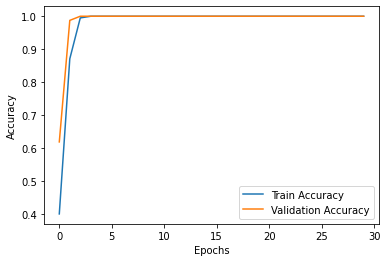

In [9]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

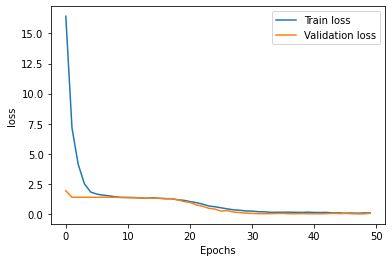

In [17]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [259]:
DATA_DIR = '/home/crysis/Workspace/STT-cnn/dataset/'

wav, sr = librosa.load(DATA_DIR + 'predict.mp3', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

FileNotFoundError: [Errno 2] No such file or directory: '/home/crysis/Workspace/STT-cnn/dataset/predict.mp3'

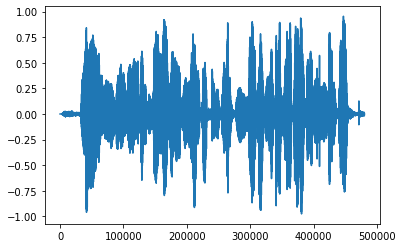

In [210]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [211]:
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 200)
padded_mfcc= np.expand_dims(padded_mfcc, 0)

In [212]:
model.predict(padded_mfcc)

array([[1.3113545e-05, 3.6631417e-11, 9.9998689e-01]], dtype=float32)

In [30]:
DATA_DIR = '/home/crysis/Workspace/STT-cnn/dataset/'
wav, sr = librosa.load(DATA_DIR + '고등어구이.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (46080,)
length: 2.88 secs


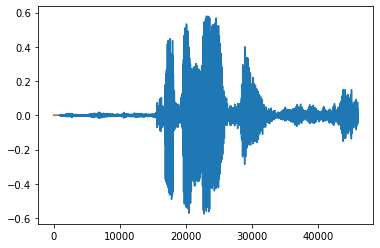

In [31]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [34]:
DATA_DIR = '/home/crysis/Workspace/STT-cnn/dataset/'
wav, sr = librosa.load(DATA_DIR + '고등어구이.wav', sr=None)
print('sr:', sr)
print('wav shape:', wav.shape)
print('length:', wav.shape[0]/float(sr), 'secs')

sr: 16000
wav shape: (46080,)
length: 2.88 secs


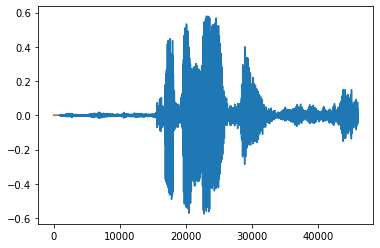

In [49]:
# raw wave
print(plt.plot(wav))
print(plt.plot(wav[0:500]))

In [36]:
mfcc = librosa.feature.mfcc(wav, sr=16000, n_mfcc=100, n_fft=400, hop_length=160)
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
padded_mfcc = pad2d(mfcc, 400)
padded_mfcc= np.expand_dims(padded_mfcc, 0)

In [37]:
model.predict(padded_mfcc)

array([[0.1899231 , 0.13559942, 0.66775316, 0.00672423]], dtype=float32)

In [38]:
a = model.predict(padded_mfcc)

In [39]:
np.argmax(a[0])

2